In [6]:
import numpy as np

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'  


# Load data
vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH).T            # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)         # shape: (neurons,)

top1 = np.argmax(vit, axis=1)

# Step 2 — ImageNet ordering: 0–397 are animals
image_is_animal = (top1 <= 397).astype(bool)

R_animals = R[image_is_animal==True]
R_inanimate = R[image_is_animal==False]

print(R_animals.shape)

from sklearn.decomposition import PCA

def intrinsic_dim_PCA(X, var=0.95):
    p = PCA().fit(X)
    cumsum = np.cumsum(p.explained_variance_ratio_)
    return np.searchsorted(cumsum, var) + 1

dim_anim = intrinsic_dim_PCA(R_animals)
dim_inan = intrinsic_dim_PCA(R_inanimate)

print("Animal manifold dim:", dim_anim)
print("Inanimate manifold dim:", dim_inan)

(63, 39209)
Animal manifold dim: 55
Inanimate manifold dim: 47


In [8]:
from sklearn.decomposition import PCA

def pca_spectrum(X, n_components=None, center=True):
    """
    X: (samples, features) = (images, neurons)
    returns: eigenvalues (explained variance per PC)
    """
    if center:
        X = X - X.mean(axis=0, keepdims=True)
    pca = PCA(n_components=n_components, svd_solver='full')
    pca.fit(X)
    return pca.explained_variance_  # λ_n

eig_anim = pca_spectrum(R_animals)
eig_inan = pca_spectrum(R_inanimate)

print("Animal PCs:", eig_anim.shape[0])
print("Inanimate PCs:", eig_inan.shape[0])



Animal PCs: 63
Inanimate PCs: 55


In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

def fit_power_law(eigs, n_min=5, n_max=100):
    """
    eigs: 1D array of eigenvalues λ_n (sorted descending)
    n_min, n_max: index range of PCs to use (1-based indices)
    returns: alpha_hat, intercept, R^2
    """
    n = np.arange(1, len(eigs) + 1)

    n_max = min(n_max, len(eigs))
    mask = (n >= n_min) & (n <= n_max)

    x = np.log(n[mask]).reshape(-1, 1)
    y = np.log(eigs[mask])

    reg = LinearRegression().fit(x, y)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    r2 = reg.score(x, y)

    alpha_hat = -slope     # because slope = -α
    return alpha_hat, intercept, r2

alpha_anim, c_anim, r2_anim = fit_power_law(eig_anim, n_min=5, n_max=100)
alpha_inan, c_inan, r2_inan = fit_power_law(eig_inan, n_min=5, n_max=100)

print(f"α_animals   ≈ {alpha_anim:.3f} (R²={r2_anim:.3f})")
print(f"α_inanimate ≈ {alpha_inan:.3f} (R²={r2_inan:.3f})")


α_animals   ≈ 2.828 (R²=0.043)
α_inanimate ≈ 3.384 (R²=0.050)


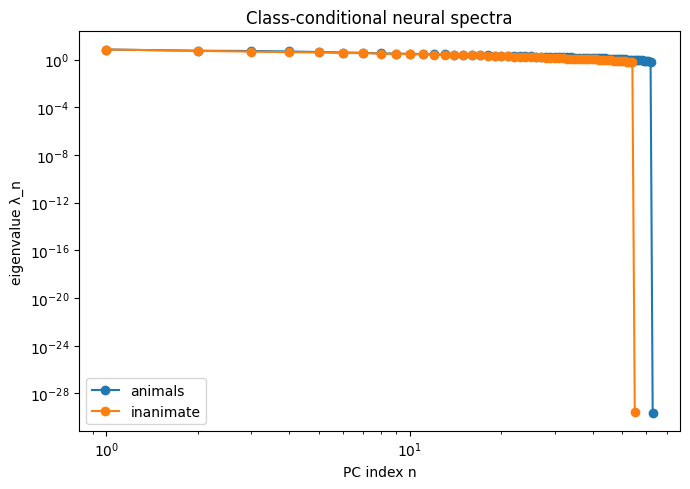

In [10]:
import matplotlib.pyplot as plt

def plot_loglog_spectrum(eigs, label, color=None):
    n = np.arange(1, len(eigs) + 1)
    plt.loglog(n, eigs, marker='o', linestyle='-', label=label)

plt.figure(figsize=(7,5))
plot_loglog_spectrum(eig_anim, 'animals')
plot_loglog_spectrum(eig_inan, 'inanimate')
plt.xlabel('PC index n')
plt.ylabel('eigenvalue λ_n')
plt.legend()
plt.title('Class-conditional neural spectra')
plt.tight_layout()
plt.show()


Animals:   α=0.529, R²=0.995, PCs used=62
Inanimate: α=0.544, R²=0.970, PCs used=54


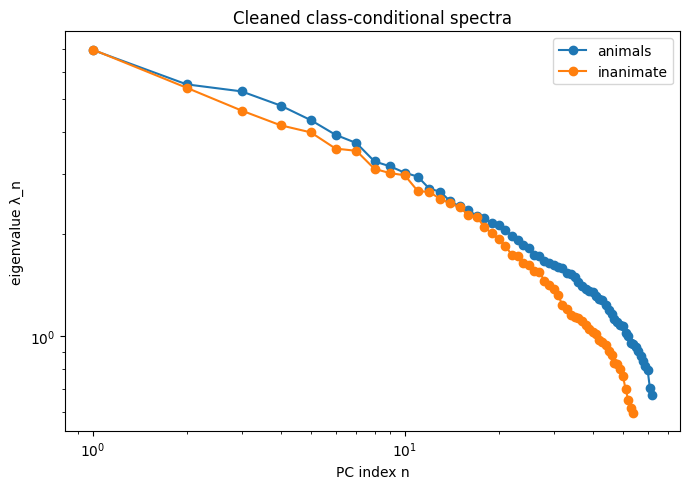

In [11]:
def cleaned_spectrum(eigs, rel_tol=1e-6):
    # keep only eigenvalues not *too* tiny vs the first one
    max_ev = eigs[0]
    mask = eigs > (rel_tol * max_ev)
    return eigs[mask]

eig_anim_clean = cleaned_spectrum(eig_anim, rel_tol=1e-6)
eig_inan_clean = cleaned_spectrum(eig_inan, rel_tol=1e-6)

alpha_anim, c_anim, r2_anim = fit_power_law(eig_anim_clean, n_min=3, n_max=30)
alpha_inan, c_inan, r2_inan = fit_power_law(eig_inan_clean, n_min=3, n_max=30)

print(f"Animals:   α={alpha_anim:.3f}, R²={r2_anim:.3f}, PCs used={len(eig_anim_clean)}")
print(f"Inanimate: α={alpha_inan:.3f}, R²={r2_inan:.3f}, PCs used={len(eig_inan_clean)}")

plt.figure(figsize=(7,5))
plot_loglog_spectrum(eig_anim_clean, 'animals')
plot_loglog_spectrum(eig_inan_clean, 'inanimate')
plt.xlabel('PC index n')
plt.ylabel('eigenvalue λ_n')
plt.legend()
plt.title('Cleaned class-conditional spectra')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'  


# Load data
vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH).T            # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)         # shape: (neurons,)

top1 = np.argmax(vit, axis=1)

# Step 2 — ImageNet ordering: 0–397 are animals
image_is_animal = (top1 <= 397).astype(bool)

R_animals = R[image_is_animal==True]
R_inanimate = R[image_is_animal==False]

print(R_animals.shape)

from sklearn.decomposition import PCA

def intrinsic_dim_PCA(X, var=0.95):
    p = PCA().fit(X)
    cumsum = np.cumsum(p.explained_variance_ratio_)
    return np.searchsorted(cumsum, var) + 1

dim_anim = intrinsic_dim_PCA(R_animals)
dim_inan = intrinsic_dim_PCA(R_inanimate)

print("Animal manifold dim:", dim_anim)
print("Inanimate manifold dim:", dim_inan)

(63, 39209)
Animal manifold dim: 55
Inanimate manifold dim: 47
